
## Setup

You will need to make a copy of this Colab notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.


In [8]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
# if not os.path.isdir('./omniglot_resized'):
#     gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
#                                         dest_path='./omniglot_resized.zip',
#                                         unzip=True)

# assert os.path.isdir('./omniglot_resized')

Unzipping...Done.


In [20]:
!unzip -o ./omniglot_resized.zip  > /dev/null

In [12]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np
import os
import random
import tensorflow as tf
from collections import defaultdict

def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    import imageio
    image = imageio.imread(filename)  # misc.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image


class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, config={}):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes

        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

        random.seed(1)
        random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
            num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
            num_train + num_val:]

    def sample_batch(self, batch_type, batch_size):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        #############################
        #### YOUR CODE GOES HERE ####
        labal_mapper = lambda x: x.split('/', 2)[-1]
        
        folders_batches = [random.sample(folders, self.num_classes) for _ in range(batch_size)]
        
        labels_and_images_batches = [
            get_images(folders_batch, map(labal_mapper, folders_batch), nb_samples=self.num_samples_per_class)  # list of tuples
            for folders_batch in folders_batches
        ]

        images_from_labels_batches = []
        for labels_and_images_batch in labels_and_images_batches:
            classes = defaultdict(list)
            for label, image_path in labels_and_images_batch:
                classes[label].append(image_file_to_array(image_path, self.dim_input))
            images_from_labels_batches.append(classes)
        

        images_getter = lambda x: list(x.values())
        all_images_list_batches = list(map(images_getter, images_from_labels_batches)) # shape B, N, k, 784

        all_image_batches = np.array(all_images_list_batches).transpose((0, 2, 1, 3))
        all_label_batches = np.tile(np.eye(self.num_classes), (batch_size, self.num_samples_per_class, 1, 1))

        # permute_eye = lambda n: np.eye(n)[np.random.permutation(n)]
        # all_label_batches = np.array([
        #     [permute_eye(self.num_classes)] * self.num_samples_per_class for _ in range(batch_size)
        # ])
        all_label_batches = np.tile(np.eye(self.num_classes), (batch_size, self.num_samples_per_class, 1, 1))
        
        # Permute test
        for bi in range(all_label_batches.shape[0]):
            permute = np.random.permutation(self.num_classes)
            all_image_batches[bi, -1, :, :] = all_image_batches[bi, -1, permute, :]
            all_label_batches[bi, -1, :, :] = all_label_batches[bi, -1, permute, :]

        assert all_image_batches.shape == (batch_size, self.num_samples_per_class, self.num_classes, 784)
        assert all_label_batches.shape == (batch_size, self.num_samples_per_class, self.num_classes, self.num_classes)
        # assert np.all(all_label_batches[:, 0, :, :] == all_label_batches[:, 1, :, :])
        #############################
        return all_image_batches.astype(np.float32), all_label_batches.astype(np.float32)


In [13]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers


class MANN(tf.keras.Model):

    def __init__(self, num_classes, samples_per_class):
        super(MANN, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        self.layer1 = tf.keras.layers.LSTM(128, return_sequences=True)
        self.layer2 = tf.keras.layers.LSTM(num_classes, return_sequences=True)

    def call(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels: [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        #############################
        #### YOUR CODE GOES HERE ####
        augmented_labels = tf.concat((input_labels[:, :-1, :, :], tf.zeros_like(input_labels[:, -1:, :, :])), 1) # make test part labels all zeros
        # tf.print(augmented_labels[:, -2, :, :], summarize=-1)
        # return None
        lstm_input = tf.concat((input_images, augmented_labels), -1)

        lstm_input = tf.transpose(lstm_input, (0, 3, 1, 2))
        shape_back = lstm_input.shape
        lstm_input = tf.reshape(lstm_input, (*lstm_input.shape[0:2], -1))
        lstm_input = tf.transpose(lstm_input, (0, 2, 1))
        
        out = self.layer1(lstm_input)
        out = self.layer2(out)

        out = tf.transpose(out, (0, 2, 1))
        out = tf.reshape(out, (*out.shape[0:2], *shape_back[2:]))
        out = tf.transpose(out, (0, 2, 3, 1))
        #############################
        return out

    def loss_function(self, preds, labels):
        """
        Computes MANN loss
        Args:
            preds: [B, K+1, N, N] network output
            labels: [B, K+1, N, N] labels
        Returns:
            scalar loss
        """
        #############################
        #### YOUR CODE GOES HERE ####
        cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        loss = cce(labels[:, -1, :, :], preds[:, -1, :, :])
        return loss
        #############################


# @tf.function
def train_step(images, labels, model, optim, eval=False):
    with tf.GradientTape() as tape:
        predictions = model(images, labels)
        loss = model.loss_function(predictions, labels)
    if not eval:
        gradients = tape.gradient(loss, model.trainable_variables)
        optim.apply_gradients(zip(gradients, model.trainable_variables))
    return predictions, loss


def main(num_classes=5, num_samples=1, meta_batch_size=16, random_seed=1234):
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    data_generator = DataGenerator(num_classes, num_samples + 1)

    o = MANN(num_classes, num_samples + 1)
    optim = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    return_value = []
    
    for step in range(25000):
        i, l = data_generator.sample_batch('train', meta_batch_size)
        _, ls = train_step(i, l, o, optim)

        if (step + 1) % 100 == 0:
            print("*" * 5 + "Iter " + str(step + 1) + "*" * 5)
            i, l = data_generator.sample_batch('test', 100)
            pred, tls = train_step(i, l, o, optim, eval=True)
            print("Train Loss:", ls.numpy(), "Test Loss:", tls.numpy())
            pred = tf.reshape(pred, [-1, num_samples + 1, num_classes, num_classes])
            pred = tf.math.argmax(pred[:, -1, :, :], axis=2)
            l = tf.math.argmax(l[:, -1, :, :], axis=2)
            test_acc = tf.reduce_mean(tf.cast(tf.math.equal(pred, l), tf.float32)).numpy()
            return_value.append((step, test_acc))
            print("Test Accuracy", test_acc)
    
    return return_value

In [ ]:
#############################
#### YOUR CODE GOES HERE ####
results = {}
for k, n in [(1, 2), (1, 3), (1, 4), (5, 4)]:
    results[k, n] = main(num_classes=n, num_samples=k, meta_batch_size=16, random_seed=1234)
#############################

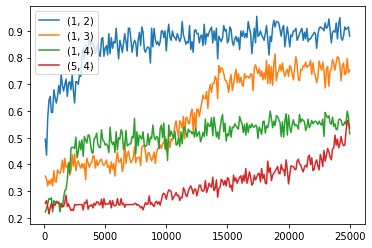

In [16]:
import matplotlib.pyplot as plt

for key, val in results.items():
    x, y = tuple(zip(*val))
    plt.plot(x, y, label=str(key))

plt.legend()